In [1]:
from spectralradex import radex
import numpy as np
from astropy import units as u 
from astropy import constants as c
from astropy.table import Table
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from multiprocessing import Pool

import warnings
warnings.filterwarnings('ignore')
plt.style.use('paper')

In [8]:
params = radex.get_example_grid_parameters()

params['tkin'] = np.arange(30, 150, 5)
params['h2'] = 10**np.arange(1, 8, 0.05)
# params['h2'] = 10**np.arange(2, 6.5, 0.5)
# params['linewidth'] = [10]
params['linewidth'] = [1, 5, 10, 20]

N_h2 = 8.5e22 
X_hnco = 10**np.arange(-10, -5, 0.05)
# X_hnco = 10**np.arange(-9, -6.5, 0.5)
params['cdmol'] = X_hnco * N_h2

params['molfile'] = 'hnco.dat'
params['fmin'] = 87.925
params['fmax'] = 87.926

renrun = False
if renrun:
    # grid_df = radex.run_grid(params, target_value="T_R (K)")
    pool=Pool(14)
    grid_df = radex.run_grid(params, target_value="T_R (K)", pool=pool)
    grid_df.to_csv('./../data/radex/grid_df.csv')
else: 
    print('[INFO] No rerun')


[INFO] No rerun


In [4]:
grid = Table.read('./../data/radex/grid_df.csv')

grid['col0'].name = 'id'
grid['h2'].name = 'nh2'
grid['cdmol'].name = 'Nh2'
grid['(4_0_4)-(3_0_3)[87.92523962 GHz]'].name = 'I_hnco'

grid.add_column(list(X_hnco) * int(len(grid)/len(X_hnco)), name='X_hnco')

mask = (grid['I_hnco']>1)&(grid['I_hnco']<5)
grid.add_column(mask*1, name='mask')

[Text(2, 1, '275.466'),
 Text(3, 1, '27.547'),
 Text(4, 1, '2.755'),
 Text(5, 1, '0.275'),
 Text(6, 1, '0.028')]

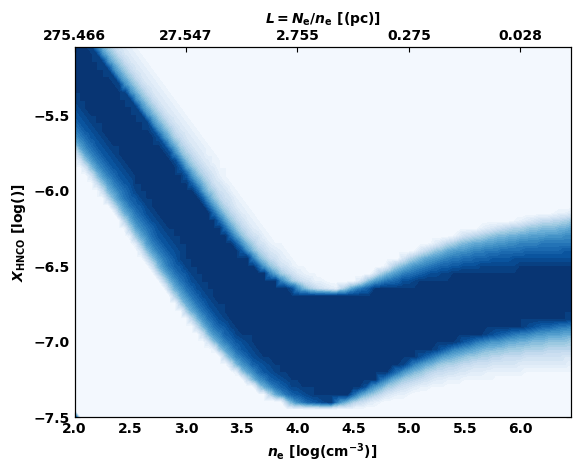

In [9]:
# cmap = plt.cm.jet(np.linspace(0., 1, 128))
# cmap = mpl.colors.LinearSegmentedColormap.from_list('my_colormap', cmap)
# cmap.set_under(cmap(0))
# cmap.set_over(cmap(-1))
# cmap.set_bad(color=cmap(0))

grid_masked = grid[grid['linewidth'] == 10]
# grid_masked = grid

for tkin in params['tkin']:

    grid_masked_tkin = grid_masked[grid_masked['tkin'] == tkin].copy()

    if tkin == params['tkin'][0]:
        z = grid_masked_tkin['mask']
    else: 
        z+=grid_masked_tkin['mask']

z[0] = z.max()+1

x = np.log10(grid_masked_tkin['nh2'])
y = np.log10(grid_masked_tkin['X_hnco'])

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.tricontourf(x, y, z, levels=np.arange(0,z.max()+1,1), cmap='Blues')
ax2 = ax1.twiny()

ax1.set_xlabel("$n_\mathrm{e}$ [log(cm$^{-3})]$")
ax1.set_ylabel("$X_\mathrm{HNCO}$ [log()]")
ax2.set_xlabel("$L = N_\mathrm{e}/n_\mathrm{e}$ [(pc)]")

def tick_function(n, N):
    L = (N/(u.cm*u.cm))/(n/(u.cm*u.cm*u.cm))
    L = L.to('pc').value
    return ["%.3f" % z for z in L]

new_tick_locations = np.array([2,3,4,5,6])
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(10**new_tick_locations, N_h2))

[Text(2, 1, '275.47'),
 Text(3, 1, '27.55'),
 Text(4, 1, '2.75'),
 Text(5, 1, '0.28'),
 Text(6, 1, '0.03')]

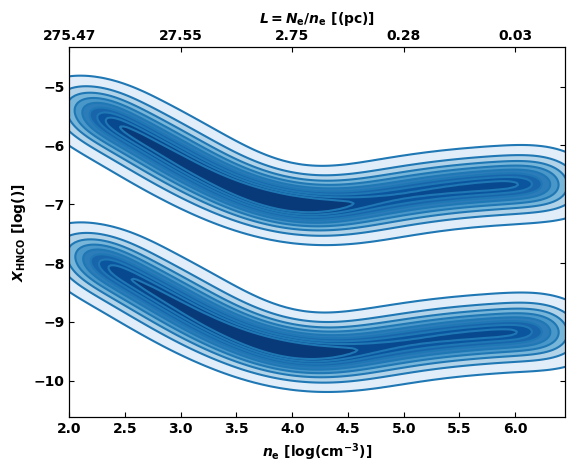

In [10]:
import seaborn as sns

grid_masked = grid[mask]
grid_masked = grid_masked[grid_masked['linewidth'] == 10]

grid_masked['nh2'] = np.log10(grid_masked['nh2'])
grid_masked['X_hnco'] = np.log10(grid_masked['X_hnco'])

grid_masked.write('./../data/radex/grid_masked.csv', overwrite=True)
grid_df_masked = pd.read_csv("./../data/radex/grid_masked.csv")

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

sns.kdeplot(ax=ax1, data=grid_df_masked, x="nh2", y="X_hnco", fill=True, cmap='Blues')
sns.kdeplot(ax=ax1, data=grid_df_masked, x="nh2", y="X_hnco", color='C0')

ax1.set_xlabel("$n_\mathrm{e}$ [log(cm$^{-3})]$")
ax1.set_ylabel("$X_\mathrm{HNCO}$ [log()]")
ax2.set_xlabel("$L = N_\mathrm{e}/n_\mathrm{e}$ [(pc)]")

def tick_function(n, N):
    L = (N/(u.cm*u.cm))/(n/(u.cm*u.cm*u.cm))
    L = L.to('pc').value
    return ["%.2f" % z for z in L]

ax1.set_xlim([grid_masked['nh2'].min(), grid_masked['nh2'].max()])
new_tick_locations = np.array([2,3,4,5,6])
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(10**new_tick_locations, N_h2))

Text(0.5, 0, 'nh2')

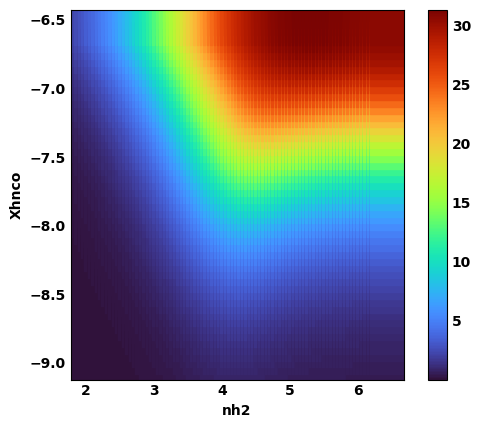

In [89]:
grid_masked = grid[grid['tkin'] == 35]

x = np.log10(grid_masked['nh2'])
y = np.log10(grid_masked['X_hnco'])
z = grid_masked['I_hnco']

fig, ax = plt.subplots()

mask = (z>2)&(z<4.5)
sc = plt.scatter(x,y,c=z,cmap='turbo',marker='s', s=700)
# ax.scatter(x[mask],y[mask], fc='none', ec='white', s=700, marker='s')

plt.colorbar(sc)

ax.set_box_aspect(1.11)

ax.set_ylabel('Xhnco')
ax.set_xlabel('nh2')